# Creating training and testing data for segmentation


In [1]:
import napari
from macrohet import dataio, tile, visualise, tools
import btrack
import os
from tqdm.auto import tqdm
from skimage.io import imread, imsave
from skimage.morphology import label
import numpy as np
import glob
import seaborn as sns

### Use cellpose to bootstrap segmentation maps

In [15]:
from cellpose import models, core
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

# defining cellpose model to use
# model = models.Cellpose(
#                         gpu=True, 
#                         model_type='cyto', 
#                         net_avg=True, 
#                         device=torch.device('cuda')
#                         )
# defining personal trained cellpose model to use
model_path = '/mnt/DATA/macrohet/upstream_development/segmentation/cellpose_training/models/macrohet_seg'
model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

def segment(frame, model = model, channels = [0,0], diameter = 198, min_size = 0):
    
    masks = model.eval(frame, 
                       channels=channels, 
                       diameter=diameter, 
                       min_size=min_size, 
                       progress=True
                       )[0]
    return masks

Using device: cuda

NVIDIA RTX A6000
Memory Usage:
Allocated: 0.7 GB
Cached:    9.3 GB
>>> GPU activated? 1


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [4]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [5]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [45]:
row = 6
column = 6
frame = 50

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [46]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images')
gt_image = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
                             set_channel=1,
                             set_time = frame,
#                             input_transforms = [input_transforms]
                            ).compute().compute().astype(np.uint16)[0,0,...]

In [47]:
gt_image.shape

(6048, 6048)

In [48]:
# optional rfp channel to aid segmentation
other_ch_image = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
                             set_channel=2,
                             set_time = frame,
#                             input_transforms = [input_transforms]
                            ).compute().compute().astype(np.uint16)[0,0,...]

### Save out GFP image

In [49]:
gt_image_fn = f'/mnt/DATA/macrohet/upstream_development/segmentation/ground_truth/raw_images/r0{row}c0{column}f0-p0-ch1sk{frame+1}fk1fl1.tiff'
imsave(gt_image_fn, gt_image, check_contrast=False)

### Define gt mask fn

In [50]:
gt_mask_fn = f'/mnt/DATA/macrohet/upstream_development/segmentation/ground_truth/semantic/r0{row}c0{column}f0-p0-ch1sk{frame+1}fk1fl1_gt_sem_masks.tiff'

###  Bootstrap the manual labelling by quickly segmenting the gt image 

In [51]:
%%time
gt_masks = segment(gt_image)

CPU times: user 57.2 s, sys: 40.7 s, total: 1min 37s
Wall time: 1min 36s


In [52]:
# need to convert from integer ID (instance segmentation) to semantic binary segmentation
gt_masks = tools.instance_to_semantic(gt_masks)
# this makes manual annotation much easier and saves data

  0%|          | 0/628 [00:00<?, ?it/s]

###### Or load previous mask for checking

In [19]:
# gt_masks = imread(gt_mask_fn)

### Solve lag time by downscaling images

In [53]:
ds_images, ds_gt_masks = visualise.downscale_images_for_manual_annotation(gt_image, gt_masks, scale_factor=4)

# Manually annotate

In [54]:
v = napari.Viewer()
v.add_image(ds_images, colormap='green', contrast_limits=[0,8000], blending = 'additive')
v.add_image(ds_images, colormap='green', contrast_limits=[0,1500], blending = 'additive', name = 'ds_images_bright', visible = False)
visualise.add_napari_grid_overlay(viewer = v, N_rows_cols=5)
v.add_labels(ds_gt_masks, color={1:'yellow'}, opacity=0.5, blending = 'additive')
v.add_image(other_ch_image, colormap='magenta', contrast_limits = [0,4000], blending = 'additive', scale=[1/4, 1/4])
@v.bind_key("s", overwrite = True)
def save_masks(v):  
    v.layers['ds_gt_masks'].save(gt_mask_fn.replace('semantic', 'backup'))
    print('Saved')
@v.bind_key("b", overwrite = True)
def show_bright_gt_image(v):  
    v.layers['ds_images_bright'].visible = 1 if v.layers['ds_images_bright'].visible == 0 else 0

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [55]:
print()


Saved


### Upscale images again and check in napari prior to saving out

In [56]:
gt_mask_updated = visualise.upscale_labels_post_manual_annotation(ds_gt_masks, 4).astype(np.uint8)

In [57]:
v = napari.Viewer()
v.add_image(gt_image, colormap='green', contrast_limits=[0,8000], blending = 'additive'
#             channel_axis=1,
#             name=["macrophage", "mtb"],
#             colormap=["green",  "magenta"],
#             contrast_limits=[[0,6000], [0,1000]], 
#             visible = True
           )
v.add_labels(gt_mask_updated)
v.add_labels(label(gt_mask_updated))

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'Labels' at 0x7f9b0c6a7070>

### Post editing save out

In [58]:
# semantic 
imsave(gt_mask_fn, gt_mask_updated)

/tmp/ipykernel_249779/347535741.py:2: UserWarning: /mnt/DATA/macrohet/upstream_development/segmentation/ground_truth/semantic/r06c06f0-p0-ch1sk51fk1fl1_gt_sem_masks.tiff is a low contrast image
  imsave(gt_mask_fn, gt_mask_updated)


In [59]:
# numpy (not really necessary)
np.save(f'/mnt/DATA/macrohet/upstream_development/segmentation/ground_truth/npy/r0{row}c0{column}f0-p0-ch1sk{frame+1}fk1fl1_gt_sem_masks', gt_mask_updated)

In [60]:
# instance
imsave(gt_mask_fn.replace('semantic', 'instance').replace('sem', 'inst'), 
       label(gt_mask_updated).astype(np.uint16))

/tmp/ipykernel_249779/301364259.py:2: UserWarning: /mnt/DATA/macrohet/upstream_development/segmentation/ground_truth/instance/r06c06f0-p0-ch1sk51fk1fl1_gt_inst_masks.tiff is a low contrast image
  imsave(gt_mask_fn.replace('semantic', 'instance').replace('sem', 'inst'),


### How many cells have I manually counted?

In [61]:
N_cells = 0
for fn in glob.glob('/mnt/DATA/macrohet/upstream_development/segmentation/ground_truth/instance/*.tiff'):
    print(os.path.basename(fn))
    N_cells+=np.max(imread(fn))

r03c07f0-p0-ch1sk16fk1fl1_gt_inst_masks.tiff
r03c05f0-p0-ch1sk75fk1fl1_gt_inst_masks.tiff
r03c08f0-p0-ch1sk61fk1fl1_gt_inst_masks.tiff
r06c08f0-p0-ch1sk61fk1fl1_gt_inst_masks.tiff
r06c07f0-p0-ch1sk21fk1fl1_gt_inst_masks.tiff
r06c06f0-p0-ch1sk51fk1fl1_gt_inst_masks.tiff
r06c09f0-p0-ch1sk1fk1fl1_gt_inst_masks.tiff
r03c06f0-p0-ch1sk35fk1fl1_gt_inst_masks.tiff
r03c04f0-p0-ch1sk2fk1fl1_gt_inst_masks.tiff
r03c09f0-p0-ch1sk71fk1fl1_gt_inst_masks.tiff


In [62]:
N_cells

6278

### What is the distribution in time of the GT images?

In [63]:
time_list = list()
for fn in glob.glob('/mnt/DATA/macrohet/upstream_development/segmentation/ground_truth/instance/*.tiff'):
    time = int(fn.split('fk')[0].split('sk')[-1])
    time_list.append(time)

<AxesSubplot:ylabel='Count'>

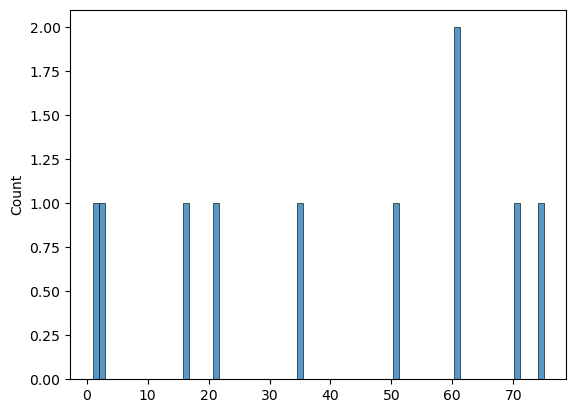

In [65]:
sns.histplot(data = time_list, bins = 75)